In [1]:
nz=201
nx=201
h=10

nt=1000
dt=0.002
ntr=100

nsnap=51
nzsnap=249
nxsnap=249

In [2]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

def read_snap(filename,n=(nsnap,nxsnap,nzsnap)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def flatten2D(data):
    return data.reshape(data.shape[0], data.shape[1]*data.shape[2])

def fracderivative(array,dt=dt,n=1):
    nt=array.shape[0]
    dw=1./(nt-1)/dt
    w=np.arange(-nt*dw/2,nt*dw/2-dw,dw).astype(complex)
    w=np.fft.ifftshift(w)
    #print(w.shape)
        
    spec=np.fft.fft(array)
    #print(spec.shape)
    spec=spec*(1j*w)**n
    
    return np.real(np.fft.ifft(spec))

def stack(array):
    n1,n2=array.shape
    return np.tile(np.reshape(np.sum(array,axis=1),(n1,1)),(1,n2))
    

def imshow(data,perc=None,clip=None,clipmin=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def hilb(data):
    return np.imag(signal.hilbert(data,axis=0))

def hilb_env(data):
    return np.abs(signal.hilbert(data,axis=0))
    
def amp_spec(data,axis=0):
    return np.abs(np.fft.rfft(data,axis=axis))


def run(app='../../exe/EI',setup='setup',np=1,nthreads=8,out=None):
    '''
    run(app,setup,np=1,nthreads=8)
    run in a bash env
    ----------------------------
    app      : application/executable to run
    setup    : setup file
    np       : number of MPI processors (default=1)
    nthreads : number of OpenMP threads (default=8)
    
    Caveat: np*nthreads should not exceed total number of CPU cores
    otherwise the running will be very slow
    '''
    
    !echo 'ulimit -s unlimited' > run.sh
    str=f"{app} {setup}"
    !echo $str >> run.sh
    !chmod +x run.sh
    if out==None:
        !./run.sh
    else:
        !./run.sh > {out}


In [3]:
#all programs in SeisJIMU needs a setup file
!cat setup_default

MODEL_SIZE              '201   201   1'
MODEL_SPACING           '10    10    1'
MODEL_ORIGIN            '0     0     0'
FILE_MODEL              'model'
MODEL_ATTRIBUTES        vp

IS_FREESURFACE          F

FILE_DATA_PREFIX        'results_fwd/dsyn_Shot'
WEIGHTING               'polygon:wei'

IF_BLOOM                F

ACQUI_GEOMETRY          spread
FS                      '20 500 500'
FR                      '40 20  0'
DR                      '0  20  0'
NR                      100

WAVELET_TYPE            'ricker'
T0                       0.25
                       # fsz   fsx  fsy  lsz   lsx    lsy  ns
#SOURCE_LINE             '26    505  500  20    505    500  1'
                       # frz   frx  fry  lrz   lrx    lry  nr
#RECEIVER_LINE           '26    10    0   26    1990   0    100'

SCOMP                     p
RCOMP                     p #'p vz vx'

IF_HICKS		F

NT           1000
DT           0.002
FPEAK        7

PARAMETER     'vp:1500:2000'

SNAPSHOT      p

JOB           g

In [4]:
!cat wei


0    1490    #offsets of vertices
1    1.5   #time instants of vertices
5   0.1

END


## True=1600/1900

In [5]:
true=np.zeros((nz,nx))
true[:,:]=1600.
true[int(nz/2)-1:int(nz/2)+1,:]=1900.
true.T.astype('float32').tofile('true')
#
!cp setup_default setup
!echo 'DIR_OUT     results_fwd' >> setup
!echo 'FILE_MODEL  true' >> setup
run(app='../../exe/FWD')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_PFEI_ExactEnv
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 19 May 20 10:16 ../../exe/FWD -> fwd_ExactEnv_FD_O2_
 Git Commit: 13ac8d1
 Git Branch: envelope+ALFAHD
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 05/20/2023
System time: 15:52:39
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_fwd
 Output directory:results_fwd/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Exact Envelope propagation (the adjoint is NOT)
2nd-order Pressure mono tilD formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *d

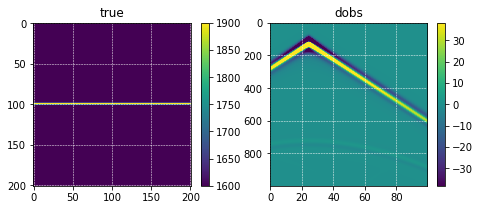

In [4]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read('true'),title='true')
plt.subplot(1,3,2); imshow(read_su('results_fwd/dsyn_Shot0001.su'), title='dobs',perc=98)

## EI ExactEnv gradient

### homo=1500

In [47]:
!makevel nz=$nz nx=$nx v000=1500 > model
!cp setup_default setup
!echo 'DIR_OUT   results_DeltaE_homo' >> setup
!echo 'DNORM     DeltaE' >> setup
run()

!cp setup_default setup
!echo 'DIR_OUT   results_DeltaEcos_homo' >> setup
!echo "DNORM     'DeltaE*cos(phobs)'" >> setup
run()

!cp setup_default setup
!echo 'DIR_OUT   results_Deltau_homo' >> setup
!echo "DNORM     'Deltau'" >> setup
run()

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_EI
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 29 May 28 12:23 ../../exe/EI -> ei_ExactEnv2_FD_O2_Wolfe_NLCG
 Git Commit: 7f7d6c5
 Git Branch: envelope+ALFAHD
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 05/28/2023
System time: 12:28:29
System timezone: +03:00
                        
       WELCOME TO SeisJIMU PFEI       
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_DeltaE_homo
 Output directory:results_DeltaE_homo/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Exact Envelope propagation (the adjoint is NOT)
2nd-order Pressure mono tilD formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|

 it----         500
 fld_q minmax values:  -290740.000       8803.74805    
 fld_p minmax values:  -121011.742       430.314575    
 fld_v minmax values:  -33.1313133       24.9080505    
 fld_u minmax values:  -19.3847008       35.2573013    
 Elapsed time to evolve field           2.21252441E-04
 Elapsed time to load boundary          1.12605095E-02
 Elapsed time to update field           1.93268061    
 Elapsed time to rm source              3.75747681E-04
 Elapsed time -----------------------
 Elapsed time to add adj & virtual src   4.27341461E-03
 Elapsed time to update adj field       1.38473892    
 Elapsed time to evolve adj field       1.73568726E-04
 Elapsed time to extract fields         1.76429749E-04
 Elapsed time to correlate             0.587502003    
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 ximage < snap_*  n1=201 perc=99
 xmovie < snap_*  n1=201

 it----         500
 fld_u minmax values:  -19.4489803       35.3003578    
 it----        1000
 fld_u minmax values:  -6.47580624       20.3045578    
 Elapsed time to add source      6.29544258E-03
 Elapsed time to save boundary   3.89754772E-04
 Elapsed time to update field   0.539701223    
 Elapsed time to evolve field    4.11295891E-03
 Elapsed time to extract field   2.75313854E-04
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 DATA_FORMAT is NOT found, take default: su
 Found proper SU scalel = 1.00000000
 SU_SCALEL is NOT found, take default: 1.00000000
 Found proper SU scalco = 1.00000000
 SU_SCALCO is NOT found, take default: 1.00000000
 SU data write success.
 JOB : gradient
 ----  Solving Av=H[s]  ----
 FILE_WAVELET_HILB is NOT found, take 0, '' or F
 WAVELET_TYPE_HILB is NOT found, take default: ricker hilbert
 Use Ricker hilbert wavelet
 RICKER_DELAYTIME

 SNAPSHOT : p
 REF_NUMBER_SNAPSHOT (NSNAPSHOT) is NOT found, take default: 50
 REF_RECT_TIME_INTEVAL (RDT) is NOT found, take default: 3.57142873E-02
 rdt, irdt = 3.40000018E-02, 17
 ----  Solving Au=s  ----
 IF_BLOOM : F
 it----         500
 fld_u minmax values:  -19.4489803       35.3003578    
 it----        1000
 fld_u minmax values:  -6.47580624       20.3045578    
 Elapsed time to add source      1.54048204E-04
 Elapsed time to save boundary   1.71726942E-03
 Elapsed time to update field   0.415874630    
 Elapsed time to evolve field    2.33054161E-04
 Elapsed time to extract field   3.04013491E-04
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 DATA_FORMAT is NOT found, take default: su
 Found proper SU scalel = 1.00000000
 SU_SCALEL is NOT found, take default: 1.00000000
 Found proper SU scalco = 1.00000000
 SU_SCALCO is NOT found, take default: 1.00000000
 SU

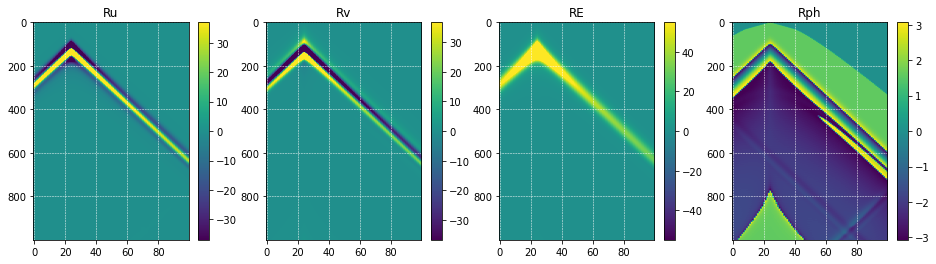

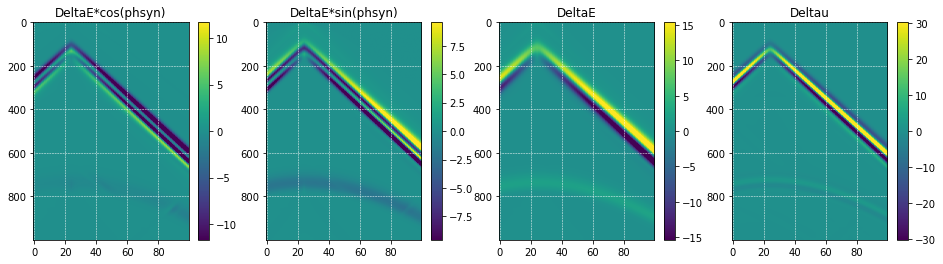

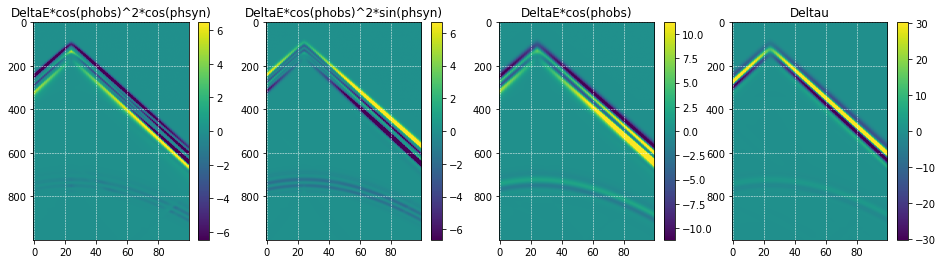

In [48]:
res1='results_DeltaE_homo/'
res2='results_DeltaEcos_homo/'
res3='results_Deltau_homo/'

usyn=read_su(res1+'Ru_Shot0001.su')
vsyn=read_su(res1+'Rv_Shot0001.su')
Esyn=np.sqrt(usyn**2+vsyn**2)
phsyn=np.arctan2(vsyn,usyn)

uobs=read_su('results_fwd/dsyn_Shot0001.su')
vobs=hilb(uobs)
Eobs=np.sqrt(uobs**2+vobs**2)
phobs=np.arctan2(vobs,uobs)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow(usyn, title='Ru',perc=98)
plt.subplot(1,4,2); imshow(vsyn, title='Rv',perc=98)
plt.subplot(1,4,3); imshow(Esyn, title='RE',perc=98)
plt.subplot(1,4,4); imshow(phsyn,title='Rph',perc=98)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow((Eobs-Esyn)*np.cos(phsyn), title='DeltaE*cos(phsyn)',perc=98)
plt.subplot(1,4,2); imshow((Eobs-Esyn)*np.sin(phsyn), title='DeltaE*sin(phsyn)',perc=98)
plt.subplot(1,4,3); imshow(Eobs-Esyn, title='DeltaE',perc=98)
plt.subplot(1,4,4); imshow(uobs-usyn, title='Deltau',perc=98)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow((Eobs-Esyn)*np.cos(phobs)**2*np.cos(phsyn), title='DeltaE*cos(phobs)^2*cos(phsyn)',perc=98)
plt.subplot(1,4,2); imshow((Eobs-Esyn)*np.cos(phobs)**2*np.sin(phsyn), title='DeltaE*cos(phobs)^2*sin(phsyn)',perc=98)
plt.subplot(1,4,3); imshow((Eobs-Esyn)*np.cos(phobs), title='DeltaE*cos(phobs)',perc=98)
plt.subplot(1,4,4); imshow(uobs-usyn, title='Deltau',perc=98)

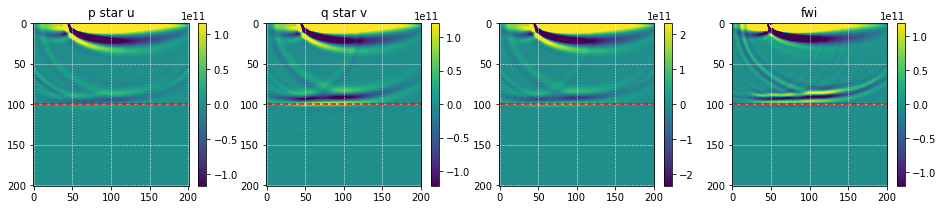

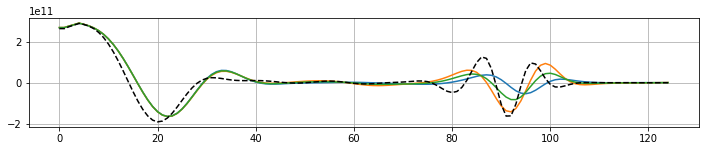

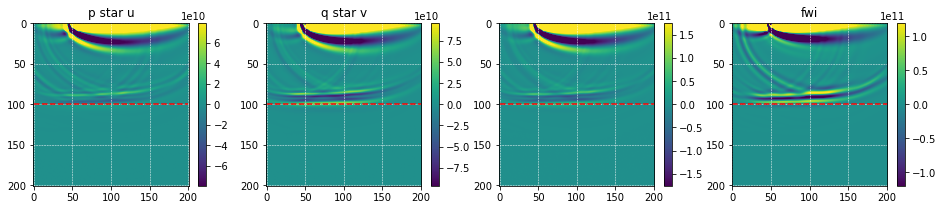

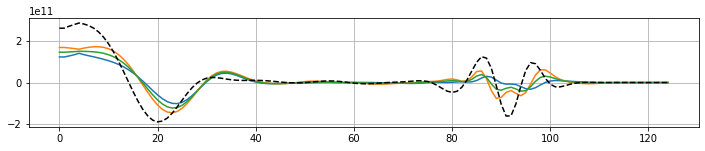

In [49]:
res1='results_DeltaE_homo/'
res2='results_DeltaEcos_homo/'
res3='results_Deltau_homo/'

grad11=read(res1+'p_star_u%rp_ddsp')
grad12=read(res1+'q_star_v%rp_ddsp')
grad21=read(res2+'p_star_u%rp_ddsp')
grad22=read(res2+'q_star_v%rp_ddsp')
grad3=read(res3+'p_star_u%rp_ddsp')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(grad11,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(grad12,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(grad11+grad12,          perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(grad3,title='fwi'   ,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=grad11[:125,100]; plt.plot(tr1)
tr2=grad12[:125,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
tr3=grad3[:125,100];  plt.plot(tr3,'k--')
plt.grid(visible=True, axis='both', which='both')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(grad21,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(grad22,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(grad21+grad22,          perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(grad3,title='fwi'   ,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=grad21[:125,100]; plt.plot(tr1)
tr2=grad22[:125,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
tr3=grad3[:125,100];  plt.plot(tr3,'k--')
plt.grid(visible=True, axis='both', which='both')

### homo=1600

In [35]:
!makevel nz=$nz nx=$nx v000=1600 > model
!cp setup_default setup
!echo 'DIR_OUT   results_DeltaE_homo' >> setup
!echo 'DNORM     DeltaE' >> setup
run()

!cp setup_default setup
!echo 'DIR_OUT   results_DeltaEcos_homo' >> setup
!echo "DNORM     'DeltaE*cos(phobs)'" >> setup
run()

!cp setup_default setup
!echo 'DIR_OUT   results_Deltau_homo' >> setup
!echo "DNORM     'Deltau'" >> setup
run()

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_EI
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 29 May 28 12:23 ../../exe/EI -> ei_ExactEnv2_FD_O2_Wolfe_NLCG
 Git Commit: 7f7d6c5
 Git Branch: envelope+ALFAHD
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 05/28/2023
System time: 12:24:10
System timezone: +03:00
                        
       WELCOME TO SeisJIMU PFEI       
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_DeltaE_homo
 Output directory:results_DeltaE_homo/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Exact Envelope propagation (the adjoint is NOT)
2nd-order Pressure mono tilD formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|

 it----         500
 fld_q minmax values:  -324268.625       8179.88818    
 fld_p minmax values:  -122784.312       492.958221    
 fld_v minmax values:  -33.1691284       24.5121346    
 fld_u minmax values:  -19.5700436       35.1583672    
 Elapsed time to evolve field           1.95026398E-04
 Elapsed time to load boundary          4.74500656E-03
 Elapsed time to update field           1.83175802    
 Elapsed time to rm source              4.05359268E-03
 Elapsed time -----------------------
 Elapsed time to add adj & virtual src   1.01103783E-02
 Elapsed time to update adj field       1.57973957    
 Elapsed time to evolve adj field       3.11660767E-03
 Elapsed time to extract fields         2.21872330E-03
 Elapsed time to correlate             0.743646622    
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 ximage < snap_*  n1=201 perc=99
 xmovie < snap_*  n1=201

 SNAPSHOT : p
 REF_NUMBER_SNAPSHOT (NSNAPSHOT) is NOT found, take default: 50
 REF_RECT_TIME_INTEVAL (RDT) is NOT found, take default: 3.57142873E-02
 rdt, irdt = 3.40000018E-02, 17
 ----  Solving Au=s  ----
 IF_BLOOM : F
 it----         500
 fld_u minmax values:  -19.5777111       35.1925888    
 it----        1000
 fld_u minmax values:  -1.64950705       2.89855289    
 Elapsed time to add source      1.65879726E-04
 Elapsed time to save boundary   4.73737717E-04
 Elapsed time to update field   0.514276087    
 Elapsed time to evolve field    2.13265419E-04
 Elapsed time to extract field   3.55809927E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 DATA_FORMAT is NOT found, take default: su
 Found proper SU scalel = 1.00000000
 SU_SCALEL is NOT found, take default: 1.00000000
 Found proper SU scalco = 1.00000000
 SU_SCALCO is NOT found, take default: 1.00000000
 SU

 SNAPSHOT : p
 REF_NUMBER_SNAPSHOT (NSNAPSHOT) is NOT found, take default: 50
 REF_RECT_TIME_INTEVAL (RDT) is NOT found, take default: 3.57142873E-02
 rdt, irdt = 3.40000018E-02, 17
 ----  Solving Au=s  ----
 IF_BLOOM : F
 it----         500
 fld_u minmax values:  -19.5777111       35.1925888    
 it----        1000
 fld_u minmax values:  -1.64950705       2.89855289    
 Elapsed time to add source      1.56402588E-04
 Elapsed time to save boundary   4.90128994E-04
 Elapsed time to update field   0.824022174    
 Elapsed time to evolve field    2.87234783E-04
 Elapsed time to extract field   2.94744968E-04
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 DATA_FORMAT is NOT found, take default: su
 Found proper SU scalel = 1.00000000
 SU_SCALEL is NOT found, take default: 1.00000000
 Found proper SU scalco = 1.00000000
 SU_SCALCO is NOT found, take default: 1.00000000
 SU

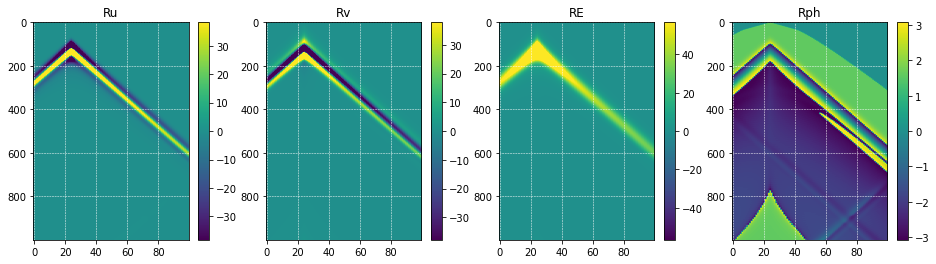

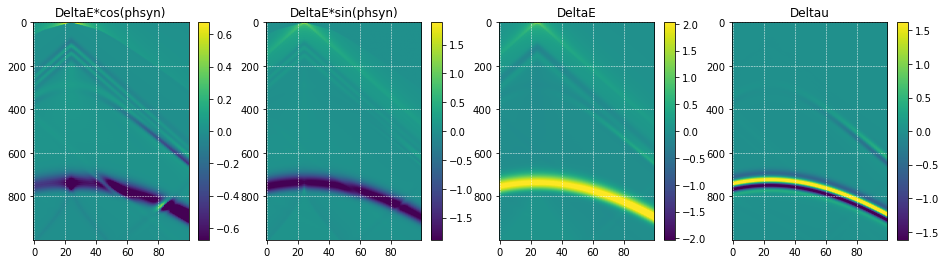

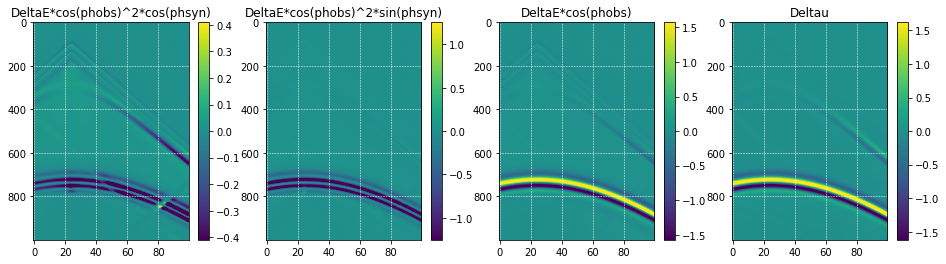

In [36]:
res1='results_DeltaE_homo/'
res2='results_DeltaEcos_homo/'
res3='results_Deltau_homo/'

usyn=read_su(res1+'Ru_Shot0001.su')
vsyn=read_su(res1+'Rv_Shot0001.su')
Esyn=np.sqrt(usyn**2+vsyn**2)
phsyn=np.arctan2(vsyn,usyn)

uobs=read_su('results_fwd/dsyn_Shot0001.su')
vobs=hilb(uobs)
Eobs=np.sqrt(uobs**2+vobs**2)
phobs=np.arctan2(vobs,uobs)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow(usyn, title='Ru',perc=98)
plt.subplot(1,4,2); imshow(vsyn, title='Rv',perc=98)
plt.subplot(1,4,3); imshow(Esyn, title='RE',perc=98)
plt.subplot(1,4,4); imshow(phsyn,title='Rph',perc=98)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow((Eobs-Esyn)*np.cos(phsyn), title='DeltaE*cos(phsyn)',perc=98)
plt.subplot(1,4,2); imshow((Eobs-Esyn)*np.sin(phsyn), title='DeltaE*sin(phsyn)',perc=98)
plt.subplot(1,4,3); imshow(Eobs-Esyn, title='DeltaE',perc=98)
plt.subplot(1,4,4); imshow(uobs-usyn, title='Deltau',perc=98)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow((Eobs-Esyn)*np.cos(phobs)**2*np.cos(phsyn), title='DeltaE*cos(phobs)^2*cos(phsyn)',perc=98)
plt.subplot(1,4,2); imshow((Eobs-Esyn)*np.cos(phobs)**2*np.sin(phsyn), title='DeltaE*cos(phobs)^2*sin(phsyn)',perc=98)
plt.subplot(1,4,3); imshow((Eobs-Esyn)*np.cos(phobs), title='DeltaE*cos(phobs)',perc=98)
plt.subplot(1,4,4); imshow(uobs-usyn, title='Deltau',perc=98)

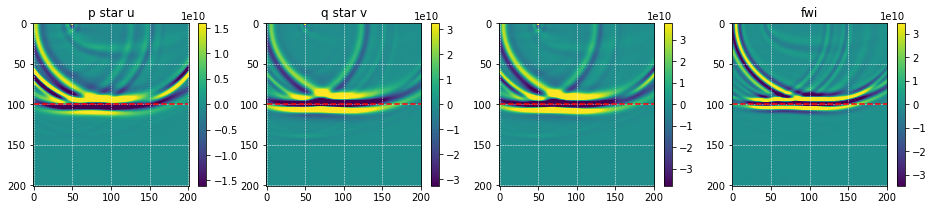

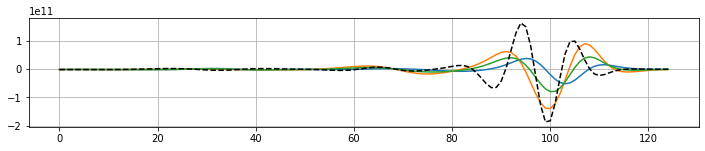

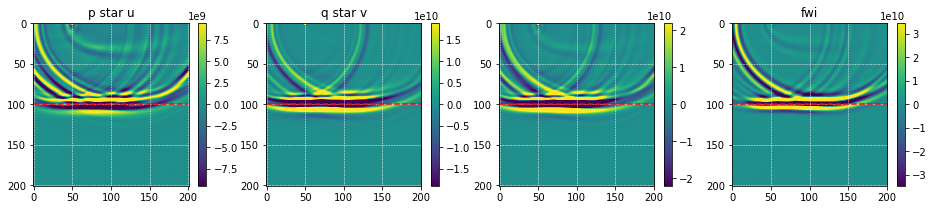

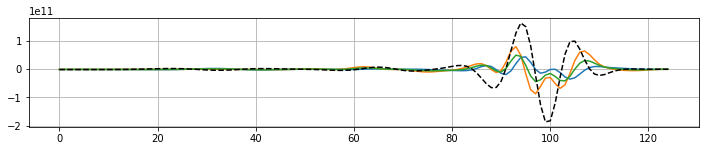

In [37]:
res1='results_DeltaE_homo/'
res2='results_DeltaEcos_homo/'
res3='results_Deltau_homo/'

grad11=read(res1+'p_star_u%rp_ddsp')
grad12=read(res1+'q_star_v%rp_ddsp')
grad21=read(res2+'p_star_u%rp_ddsp')
grad22=read(res2+'q_star_v%rp_ddsp')
grad3=read(res3+'p_star_u%rp_ddsp')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(grad11,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(grad12,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(grad11+grad12,          perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(grad3,title='fwi'   ,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=grad11[:125,100]; plt.plot(tr1)
tr2=grad12[:125,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
tr3=grad3[:125,100];  plt.plot(tr3,'k--')
plt.grid(visible=True, axis='both', which='both')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(grad21,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(grad22,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(grad21+grad22,          perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(grad3,title='fwi'   ,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=grad21[:125,100]; plt.plot(tr1)
tr2=grad22[:125,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
tr3=grad3[:125,100];  plt.plot(tr3,'k--')
plt.grid(visible=True, axis='both', which='both')

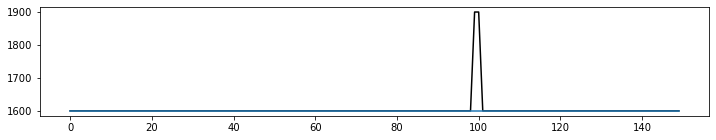

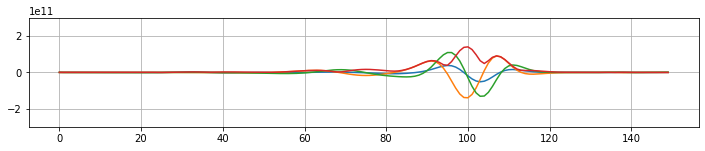

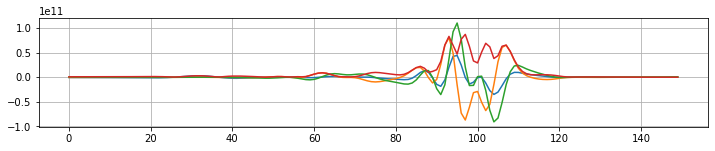

In [38]:
plt.figure(figsize=(12,2))
plt.plot(read('true')[:150,100],'k')
plt.plot(read('model')[:150,100])

plt.figure(figsize=(12,2))
tr1=grad11[:150,100]; plt.plot(tr1)
tr2=grad12[:150,100]; plt.plot(tr2)
plt.plot(hilb(tr2))
plt.plot(np.sqrt(tr1**2+tr2**2))
plt.ylim([-3e11,3e11])
plt.grid(visible=True, axis='both', which='both')

plt.figure(figsize=(12,2))
tr1=grad21[:150,100]; plt.plot(tr1)
tr2=grad22[:150,100]; plt.plot(tr2)
plt.plot(hilb(tr2))
plt.plot(np.sqrt(tr1**2+tr2**2))
plt.grid(visible=True, axis='both', which='both')

#### obs: v_star_DeltaEsin(ph) is approx the scaled hilb transf of u_star_DeltaEcos(ph)

### homo=1800

In [39]:
!makevel nz=$nz nx=$nx v000=1800 > model
!cp setup_default setup
!echo 'DIR_OUT   results_DeltaE_homo' >> setup
!echo 'DNORM     DeltaE' >> setup
run()

!cp setup_default setup
!echo 'DIR_OUT   results_DeltaEcos_homo' >> setup
!echo "DNORM     'DeltaE*cos(phobs)'" >> setup
run()

!cp setup_default setup
!echo 'DIR_OUT   results_Deltau_homo' >> setup
!echo "DNORM     'Deltau'" >> setup
run()

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_EI
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 29 May 28 12:23 ../../exe/EI -> ei_ExactEnv2_FD_O2_Wolfe_NLCG
 Git Commit: 7f7d6c5
 Git Branch: envelope+ALFAHD
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 05/28/2023
System time: 12:25:37
System timezone: +03:00
                        
       WELCOME TO SeisJIMU PFEI       
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_DeltaE_homo
 Output directory:results_DeltaE_homo/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Exact Envelope propagation (the adjoint is NOT)
2nd-order Pressure mono tilD formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|

 it----         500
 fld_q minmax values:  -375283.000       7204.35547    
 fld_p minmax values:  -179972.812       745.001831    
 fld_v minmax values:  -33.2207031       23.9051743    
 fld_u minmax values:  -19.7792091       34.9505463    
 Elapsed time to evolve field           1.85012817E-04
 Elapsed time to load boundary          1.68771744E-02
 Elapsed time to update field           1.59593391    
 Elapsed time to rm source              2.12669373E-04
 Elapsed time -----------------------
 Elapsed time to add adj & virtual src   4.84514236E-03
 Elapsed time to update adj field       1.65437555    
 Elapsed time to evolve adj field       1.80816650E-03
 Elapsed time to extract fields         1.68323517E-04
 Elapsed time to correlate             0.568073273    
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 ximage < snap_*  n1=201 perc=99
 xmovie < snap_*  n1=201

 SNAPSHOT : p
 REF_NUMBER_SNAPSHOT (NSNAPSHOT) is NOT found, take default: 50
 REF_RECT_TIME_INTEVAL (RDT) is NOT found, take default: 3.57142873E-02
 rdt, irdt = 3.40000018E-02, 17
 ----  Solving Au=s  ----
 IF_BLOOM : F
 it----         500
 fld_u minmax values:  -19.8247967       34.9952850    
 it----        1000
 fld_u minmax values: -0.155442461      0.102267168    
 Elapsed time to add source      1.54852867E-04
 Elapsed time to save boundary   7.19428062E-03
 Elapsed time to update field   0.398118019    
 Elapsed time to evolve field    9.05007124E-04
 Elapsed time to extract field   6.85405731E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 DATA_FORMAT is NOT found, take default: su
 Found proper SU scalel = 1.00000000
 SU_SCALEL is NOT found, take default: 1.00000000
 Found proper SU scalco = 1.00000000
 SU_SCALCO is NOT found, take default: 1.00000000
 SU

 SNAPSHOT : p
 REF_NUMBER_SNAPSHOT (NSNAPSHOT) is NOT found, take default: 50
 REF_RECT_TIME_INTEVAL (RDT) is NOT found, take default: 3.57142873E-02
 rdt, irdt = 3.40000018E-02, 17
 ----  Solving Au=s  ----
 IF_BLOOM : F
 it----         500
 fld_u minmax values:  -19.8247967       34.9952850    
 it----        1000
 fld_u minmax values: -0.155442461      0.102267168    
 Elapsed time to add source      1.59800053E-04
 Elapsed time to save boundary   4.59843874E-03
 Elapsed time to update field   0.662031233    
 Elapsed time to evolve field    2.14290619E-03
 Elapsed time to extract field   2.45296955E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 DATA_FORMAT is NOT found, take default: su
 Found proper SU scalel = 1.00000000
 SU_SCALEL is NOT found, take default: 1.00000000
 Found proper SU scalco = 1.00000000
 SU_SCALCO is NOT found, take default: 1.00000000
 SU

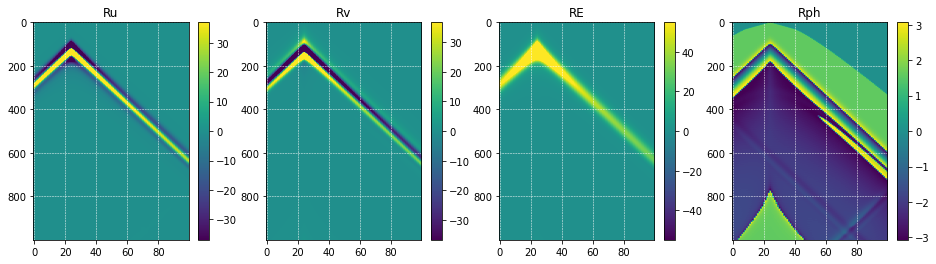

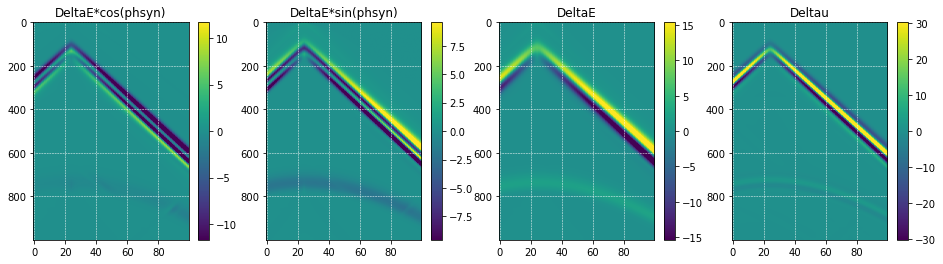

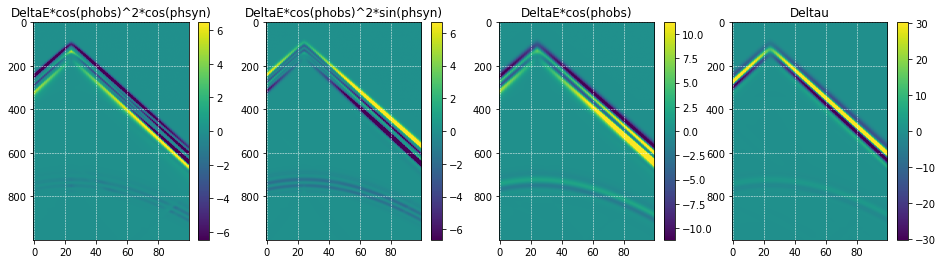

In [44]:
res1='results_DeltaE_homo/'
res2='results_DeltaEcos_homo/'
res3='results_Deltau_homo/'

usyn=read_su(res1+'Ru_Shot0001.su')
vsyn=read_su(res1+'Rv_Shot0001.su')
Esyn=np.sqrt(usyn**2+vsyn**2)
phsyn=np.arctan2(vsyn,usyn)

uobs=read_su('results_fwd/dsyn_Shot0001.su')
vobs=hilb(uobs)
Eobs=np.sqrt(uobs**2+vobs**2)
phobs=np.arctan2(vobs,uobs)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow(usyn, title='Ru',perc=98)
plt.subplot(1,4,2); imshow(vsyn, title='Rv',perc=98)
plt.subplot(1,4,3); imshow(Esyn, title='RE',perc=98)
plt.subplot(1,4,4); imshow(phsyn,title='Rph',perc=98)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow((Eobs-Esyn)*np.cos(phsyn), title='DeltaE*cos(phsyn)',perc=98)
plt.subplot(1,4,2); imshow((Eobs-Esyn)*np.sin(phsyn), title='DeltaE*sin(phsyn)',perc=98)
plt.subplot(1,4,3); imshow(Eobs-Esyn, title='DeltaE',perc=98)
plt.subplot(1,4,4); imshow(uobs-usyn, title='Deltau',perc=98)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow((Eobs-Esyn)*np.cos(phobs)**2*np.cos(phsyn), title='DeltaE*cos(phobs)^2*cos(phsyn)',perc=98)
plt.subplot(1,4,2); imshow((Eobs-Esyn)*np.cos(phobs)**2*np.sin(phsyn), title='DeltaE*cos(phobs)^2*sin(phsyn)',perc=98)
plt.subplot(1,4,3); imshow((Eobs-Esyn)*np.cos(phobs), title='DeltaE*cos(phobs)',perc=98)
plt.subplot(1,4,4); imshow(uobs-usyn, title='Deltau',perc=98)

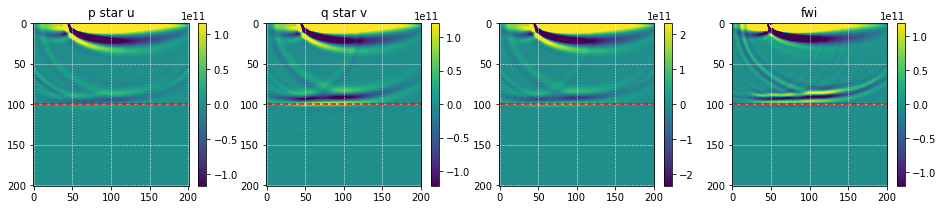

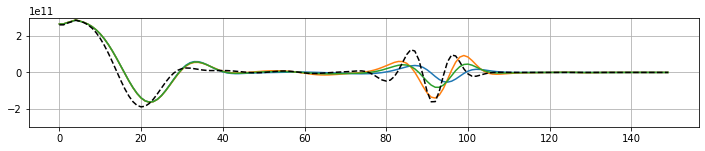

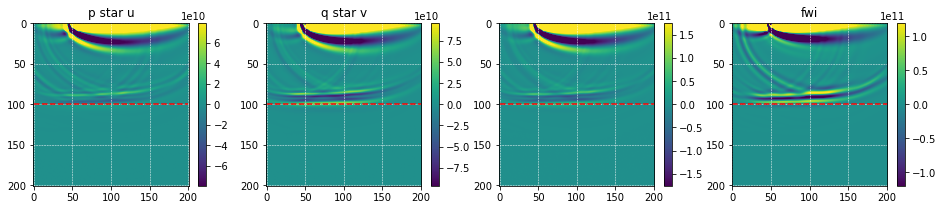

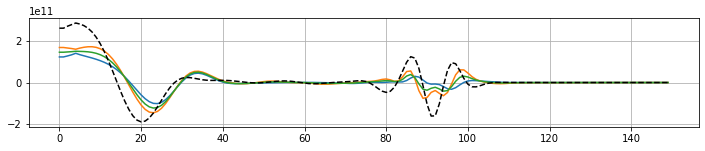

In [45]:
res1='results_DeltaE_homo/'
res2='results_DeltaEcos_homo/'
res3='results_Deltau_homo/'

grad11=read(res1+'p_star_u%rp_ddsp')
grad12=read(res1+'q_star_v%rp_ddsp')
grad21=read(res2+'p_star_u%rp_ddsp')
grad22=read(res2+'q_star_v%rp_ddsp')
grad3=read(res3+'p_star_u%rp_ddsp')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(grad11,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(grad12,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(grad11+grad12,          perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(grad3,title='fwi'   ,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=grad11[:150,100]; plt.plot(tr1)
tr2=grad12[:150,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
tr3=grad3[:150,100];  plt.plot(tr3,'k--')
plt.ylim([-3e11,3e11])
plt.grid(visible=True, axis='both', which='both')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(grad21,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(grad22,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(grad21+grad22,          perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(grad3,title='fwi'   ,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=grad21[:150,100]; plt.plot(tr1)
tr2=grad22[:150,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
tr3=grad3[:150,100];  plt.plot(tr3,'k--')
plt.grid(visible=True, axis='both', which='both')

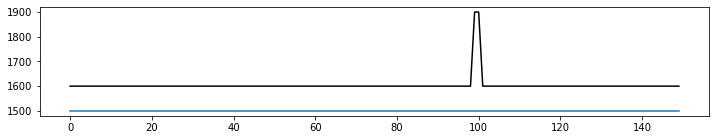

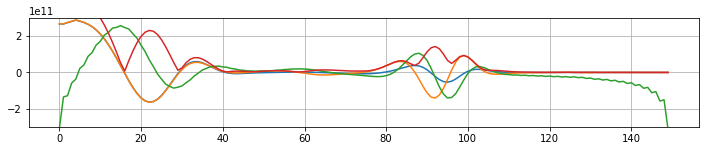

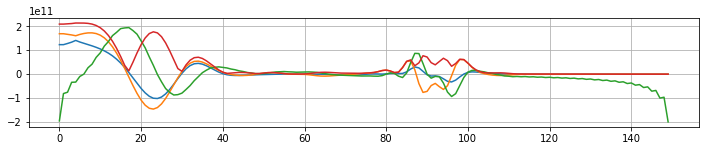

In [46]:
plt.figure(figsize=(12,2))
plt.plot(read('true')[:150,100],'k')
plt.plot(read('model')[:150,100])

plt.figure(figsize=(12,2))
tr1=grad11[:150,100]; plt.plot(tr1)
tr2=grad12[:150,100]; plt.plot(tr2)
plt.plot(hilb(tr2))
plt.plot(np.sqrt(tr1**2+tr2**2))
plt.ylim([-3e11,3e11])
plt.grid(visible=True, axis='both', which='both')

plt.figure(figsize=(12,2))
tr1=grad21[:150,100]; plt.plot(tr1)
tr2=grad22[:150,100]; plt.plot(tr2)
plt.plot(hilb(tr2))
plt.plot(np.sqrt(tr1**2+tr2**2))
plt.grid(visible=True, axis='both', which='both')

### 2layer=1500/2000

In [50]:
model=np.zeros((nz,nx))
model[:,:]=1500.
model[int(nz/2)-1:int(nz/2)+1,:]=2000.
model.T.astype('float32').tofile('model')

!cp setup_default setup
!echo 'DIR_OUT   results_DeltaE_2layer' >> setup
!echo 'DNORM     DeltaE' >> setup
run()

!cp setup_default setup
!echo 'DIR_OUT   results_DeltaEcos_2layer' >> setup
!echo "DNORM     'DeltaE*cos(phobs)'" >> setup
run()

!cp setup_default setup
!echo 'DIR_OUT   results_Deltau_2layer' >> setup
!echo "DNORM     'Deltau'" >> setup
run()

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_EI
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 29 May 28 12:23 ../../exe/EI -> ei_ExactEnv2_FD_O2_Wolfe_NLCG
 Git Commit: 7f7d6c5
 Git Branch: envelope+ALFAHD
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 05/28/2023
System time: 12:46:36
System timezone: +03:00
                        
       WELCOME TO SeisJIMU PFEI       
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_DeltaE_2layer
 Output directory:results_DeltaE_2layer/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Exact Envelope propagation (the adjoint is NOT)
2nd-order Pressure mono tilD formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL 

 it----         500
 fld_q minmax values:  -117673.539       92946.6484    
 fld_p minmax values:  -156712.516       141029.750    
 fld_v minmax values:  -36.1432571       28.8786831    
 fld_u minmax values:  -20.7776241       39.8931274    
 Elapsed time to evolve field           2.15053558E-04
 Elapsed time to load boundary          1.51886940E-02
 Elapsed time to update field           2.38602304    
 Elapsed time to rm source              6.51836395E-04
 Elapsed time -----------------------
 Elapsed time to add adj & virtual src   9.50765610E-03
 Elapsed time to update adj field       1.73905182    
 Elapsed time to evolve adj field       3.17430496E-03
 Elapsed time to extract fields         6.15739822E-03
 Elapsed time to correlate             0.814232349    
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 ximage < snap_*  n1=201 perc=99
 xmovie < snap_*  n1=201

 it----         500
 fld_u minmax values:  -20.7061596       39.9485626    
 it----        1000
 fld_u minmax values:  -6.05206728       18.5863552    
 Elapsed time to add source      7.01546669E-04
 Elapsed time to save boundary   3.48472595E-03
 Elapsed time to update field   0.997784615    
 Elapsed time to evolve field    3.32975388E-03
 Elapsed time to extract field   8.06725025E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 DATA_FORMAT is NOT found, take default: su
 Found proper SU scalel = 1.00000000
 SU_SCALEL is NOT found, take default: 1.00000000
 Found proper SU scalco = 1.00000000
 SU_SCALCO is NOT found, take default: 1.00000000
 SU data write success.
 JOB : gradient
 ----  Solving Av=H[s]  ----
 FILE_WAVELET_HILB is NOT found, take 0, '' or F
 WAVELET_TYPE_HILB is NOT found, take default: ricker hilbert
 Use Ricker hilbert wavelet
 RICKER_DELAYTIME

 it----         500
 fld_u minmax values:  -20.7061596       39.9485626    
 it----        1000
 fld_u minmax values:  -6.05206728       18.5863552    
 Elapsed time to add source      2.31432915E-03
 Elapsed time to save boundary   4.40102816E-03
 Elapsed time to update field   0.474863827    
 Elapsed time to evolve field    4.16457653E-04
 Elapsed time to extract field   2.92444229E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 DATA_FORMAT is NOT found, take default: su
 Found proper SU scalel = 1.00000000
 SU_SCALEL is NOT found, take default: 1.00000000
 Found proper SU scalco = 1.00000000
 SU_SCALCO is NOT found, take default: 1.00000000
 SU data write success.
 JOB : gradient
 ----  Solving Av=H[s]  ----
 FILE_WAVELET_HILB is NOT found, take 0, '' or F
 WAVELET_TYPE_HILB is NOT found, take default: ricker hilbert
 Use Ricker hilbert wavelet
 RICKER_DELAYTIME

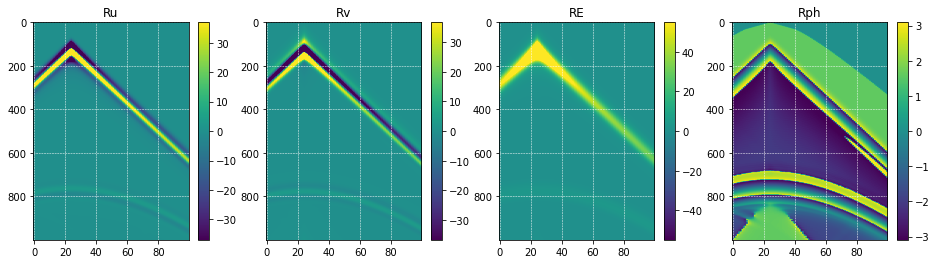

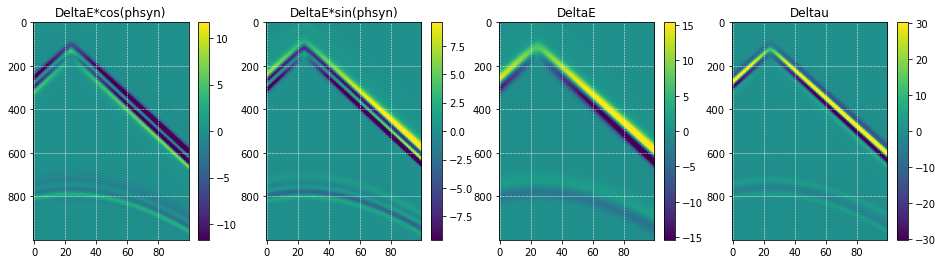

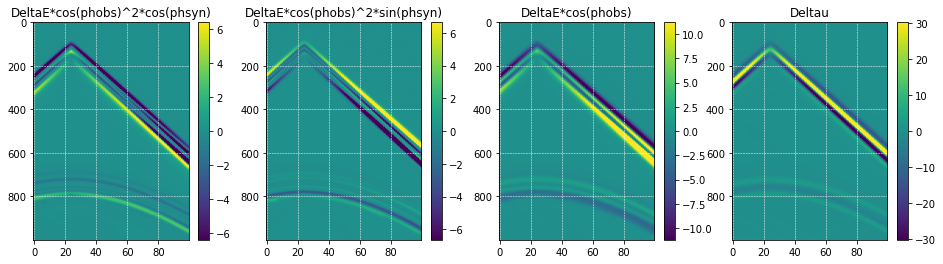

In [51]:
res1='results_DeltaE_2layer/'
res2='results_DeltaEcos_2layer/'
res3='results_Deltau_2layer/'

usyn=read_su(res1+'Ru_Shot0001.su')
vsyn=read_su(res1+'Rv_Shot0001.su')
Esyn=np.sqrt(usyn**2+vsyn**2)
phsyn=np.arctan2(vsyn,usyn)

uobs=read_su('results_fwd/dsyn_Shot0001.su')
vobs=hilb(uobs)
Eobs=np.sqrt(uobs**2+vobs**2)
phobs=np.arctan2(vobs,uobs)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow(usyn, title='Ru',perc=98)
plt.subplot(1,4,2); imshow(vsyn, title='Rv',perc=98)
plt.subplot(1,4,3); imshow(Esyn, title='RE',perc=98)
plt.subplot(1,4,4); imshow(phsyn,title='Rph',perc=98)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow((Eobs-Esyn)*np.cos(phsyn), title='DeltaE*cos(phsyn)',perc=98)
plt.subplot(1,4,2); imshow((Eobs-Esyn)*np.sin(phsyn), title='DeltaE*sin(phsyn)',perc=98)
plt.subplot(1,4,3); imshow(Eobs-Esyn, title='DeltaE',perc=98)
plt.subplot(1,4,4); imshow(uobs-usyn, title='Deltau',perc=98)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow((Eobs-Esyn)*np.cos(phobs)**2*np.cos(phsyn), title='DeltaE*cos(phobs)^2*cos(phsyn)',perc=98)
plt.subplot(1,4,2); imshow((Eobs-Esyn)*np.cos(phobs)**2*np.sin(phsyn), title='DeltaE*cos(phobs)^2*sin(phsyn)',perc=98)
plt.subplot(1,4,3); imshow((Eobs-Esyn)*np.cos(phobs), title='DeltaE*cos(phobs)',perc=98)
plt.subplot(1,4,4); imshow(uobs-usyn, title='Deltau',perc=98)

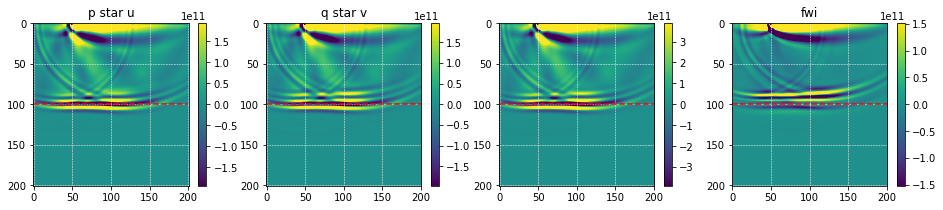

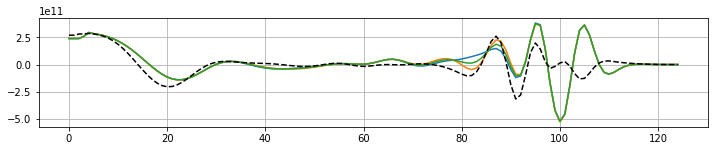

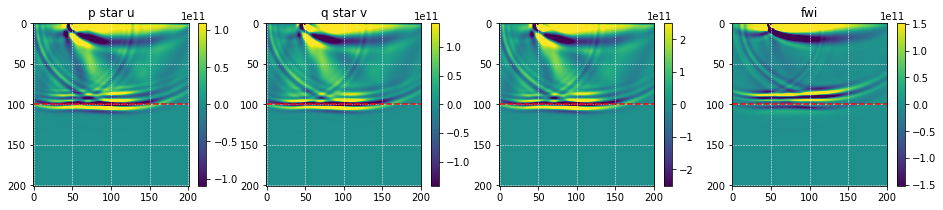

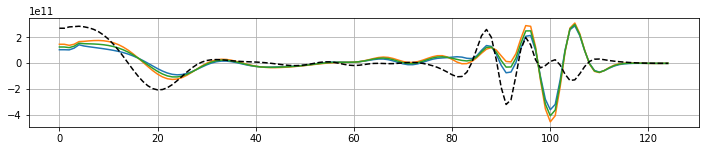

In [52]:
res1='results_DeltaE_2layer/'
res2='results_DeltaEcos_2layer/'
res3='results_Deltau_2layer/'

grad11=read(res1+'p_star_u%rp_ddsp')
grad12=read(res1+'q_star_v%rp_ddsp')
grad21=read(res2+'p_star_u%rp_ddsp')
grad22=read(res2+'q_star_v%rp_ddsp')
grad3=read(res3+'p_star_u%rp_ddsp')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(grad11,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(grad12,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(grad11+grad12,          perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(grad3,title='fwi'   ,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=grad11[:125,100]; plt.plot(tr1)
tr2=grad12[:125,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
tr3=grad3[:125,100];  plt.plot(tr3,'k--')
plt.grid(visible=True, axis='both', which='both')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(grad21,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(grad22,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(grad21+grad22,          perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(grad3,title='fwi'   ,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=grad21[:125,100]; plt.plot(tr1)
tr2=grad22[:125,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
tr3=grad3[:125,100];  plt.plot(tr3,'k--')
plt.grid(visible=True, axis='both', which='both')

### 2layer=1700/1800

In [53]:
model=np.zeros((nz,nx))
model[:,:]=1700.
model[int(nz/2)-1:int(nz/2)+1,:]=1800.
model.T.astype('float32').tofile('model')

!cp setup_default setup
!echo 'DIR_OUT   results_DeltaE_2layer' >> setup
!echo 'DNORM     DeltaE' >> setup
run()

!cp setup_default setup
!echo 'DIR_OUT   results_DeltaEcos_2layer' >> setup
!echo "DNORM     'DeltaE*cos(phobs)'" >> setup
run()

!cp setup_default setup
!echo 'DIR_OUT   results_Deltau_2layer' >> setup
!echo "DNORM     'Deltau'" >> setup
run()

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_EI
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 29 May 28 12:23 ../../exe/EI -> ei_ExactEnv2_FD_O2_Wolfe_NLCG
 Git Commit: 7f7d6c5
 Git Branch: envelope+ALFAHD
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 05/28/2023
System time: 12:48:11
System timezone: +03:00
                        
       WELCOME TO SeisJIMU PFEI       
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_DeltaE_2layer
 Output directory:results_DeltaE_2layer/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Exact Envelope propagation (the adjoint is NOT)
2nd-order Pressure mono tilD formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL 

 SU data write success.
 ----  Solving adjoint eqn & xcorrelate  ----
 it----        1000
 fld_q minmax values:   0.00000000       0.00000000    
 fld_p minmax values:   0.00000000       0.00000000    
 fld_v minmax values:  -8.84815976E-02   2.27355504    
 fld_u minmax values: -0.297372818      0.207135707    
 it----         500
 fld_q minmax values:  -239170.641       7474.75830    
 fld_p minmax values:  -66360.0938       76277.8672    
 fld_v minmax values:  -33.9627800       24.2300682    
 fld_u minmax values:  -20.0586300       35.9341927    
 Elapsed time to evolve field           4.07171249E-03
 Elapsed time to load boundary          1.01513863E-02
 Elapsed time to update field           2.05157518    
 Elapsed time to rm source              1.00421906E-03
 Elapsed time -----------------------
 Elapsed time to add adj & virtual src   5.98669052E-03
 Elapsed time to update adj field       1.66017389    
 Elapsed time to evolve adj field       2.02178955E-04
 Elapsed time to e

 SNAPSHOT : p
 REF_NUMBER_SNAPSHOT (NSNAPSHOT) is NOT found, take default: 50
 REF_RECT_TIME_INTEVAL (RDT) is NOT found, take default: 3.57142873E-02
 rdt, irdt = 3.40000018E-02, 17
 ----  Solving Au=s  ----
 IF_BLOOM : F
 it----         500
 fld_u minmax values:  -20.0613861       36.0933342    
 it----        1000
 fld_u minmax values: -0.302883148      0.208207041    
 Elapsed time to add source      3.32784653E-03
 Elapsed time to save boundary   5.04994392E-03
 Elapsed time to update field   0.706723452    
 Elapsed time to evolve field    1.80482864E-04
 Elapsed time to extract field   3.05831432E-04
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 DATA_FORMAT is NOT found, take default: su
 Found proper SU scalel = 1.00000000
 SU_SCALEL is NOT found, take default: 1.00000000
 Found proper SU scalco = 1.00000000
 SU_SCALCO is NOT found, take default: 1.00000000
 SU

 SNAPSHOT : p
 REF_NUMBER_SNAPSHOT (NSNAPSHOT) is NOT found, take default: 50
 REF_RECT_TIME_INTEVAL (RDT) is NOT found, take default: 3.57142873E-02
 rdt, irdt = 3.40000018E-02, 17
 ----  Solving Au=s  ----
 IF_BLOOM : F
 it----         500
 fld_u minmax values:  -20.0613861       36.0933342    
 it----        1000
 fld_u minmax values: -0.302883148      0.208207041    
 Elapsed time to add source      1.54882669E-04
 Elapsed time to save boundary   1.25116110E-03
 Elapsed time to update field   0.413931876    
 Elapsed time to evolve field    2.82099843E-03
 Elapsed time to extract field   1.23476982E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 DATA_FORMAT is NOT found, take default: su
 Found proper SU scalel = 1.00000000
 SU_SCALEL is NOT found, take default: 1.00000000
 Found proper SU scalco = 1.00000000
 SU_SCALCO is NOT found, take default: 1.00000000
 SU

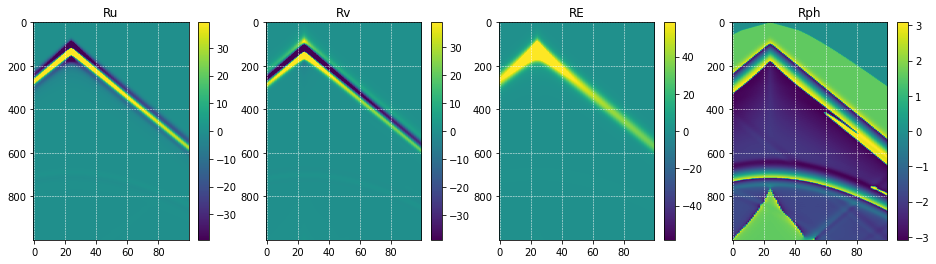

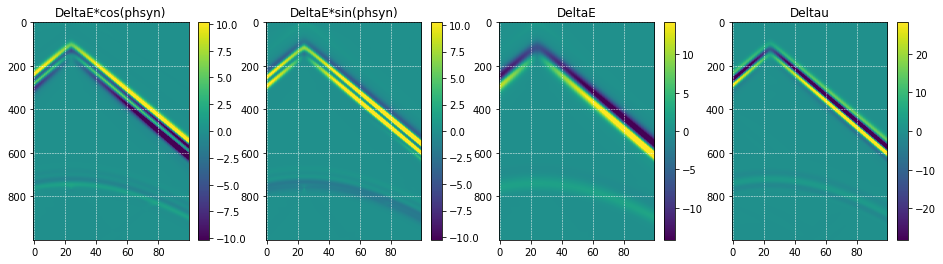

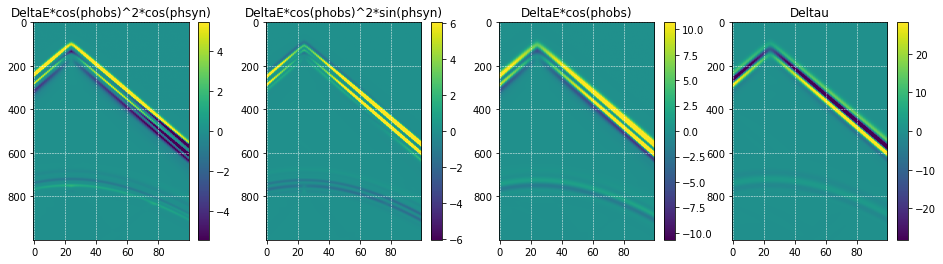

In [54]:
res1='results_DeltaE_2layer/'
res2='results_DeltaEcos_2layer/'
res3='results_Deltau_2layer/'

usyn=read_su(res1+'Ru_Shot0001.su')
vsyn=read_su(res1+'Rv_Shot0001.su')
Esyn=np.sqrt(usyn**2+vsyn**2)
phsyn=np.arctan2(vsyn,usyn)

uobs=read_su('results_fwd/dsyn_Shot0001.su')
vobs=hilb(uobs)
Eobs=np.sqrt(uobs**2+vobs**2)
phobs=np.arctan2(vobs,uobs)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow(usyn, title='Ru',perc=98)
plt.subplot(1,4,2); imshow(vsyn, title='Rv',perc=98)
plt.subplot(1,4,3); imshow(Esyn, title='RE',perc=98)
plt.subplot(1,4,4); imshow(phsyn,title='Rph',perc=98)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow((Eobs-Esyn)*np.cos(phsyn), title='DeltaE*cos(phsyn)',perc=98)
plt.subplot(1,4,2); imshow((Eobs-Esyn)*np.sin(phsyn), title='DeltaE*sin(phsyn)',perc=98)
plt.subplot(1,4,3); imshow(Eobs-Esyn, title='DeltaE',perc=98)
plt.subplot(1,4,4); imshow(uobs-usyn, title='Deltau',perc=98)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1); imshow((Eobs-Esyn)*np.cos(phobs)**2*np.cos(phsyn), title='DeltaE*cos(phobs)^2*cos(phsyn)',perc=98)
plt.subplot(1,4,2); imshow((Eobs-Esyn)*np.cos(phobs)**2*np.sin(phsyn), title='DeltaE*cos(phobs)^2*sin(phsyn)',perc=98)
plt.subplot(1,4,3); imshow((Eobs-Esyn)*np.cos(phobs), title='DeltaE*cos(phobs)',perc=98)
plt.subplot(1,4,4); imshow(uobs-usyn, title='Deltau',perc=98)

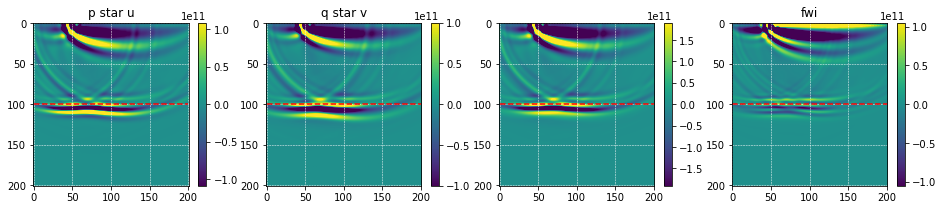

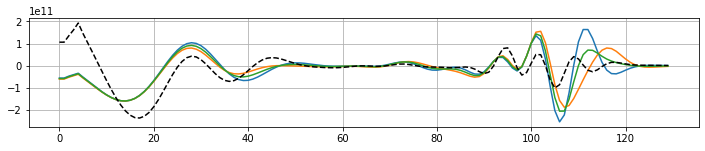

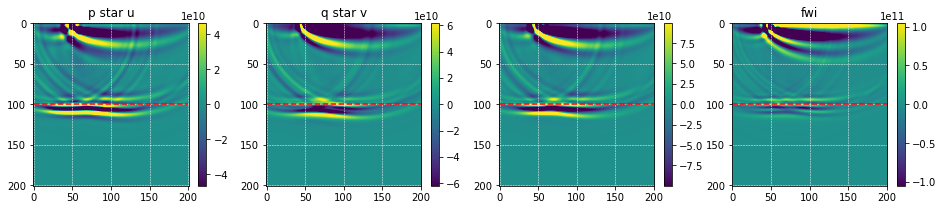

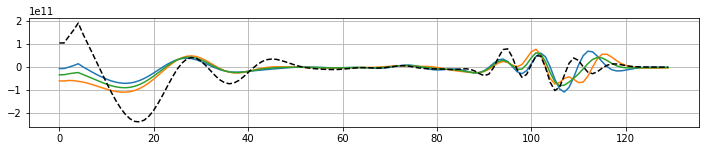

In [56]:
res1='results_DeltaE_2layer/'
res2='results_DeltaEcos_2layer/'
res3='results_Deltau_2layer/'

grad11=read(res1+'p_star_u%rp_ddsp')
grad12=read(res1+'q_star_v%rp_ddsp')
grad21=read(res2+'p_star_u%rp_ddsp')
grad22=read(res2+'q_star_v%rp_ddsp')
grad3=read(res3+'p_star_u%rp_ddsp')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(grad11,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(grad12,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(grad11+grad12,          perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(grad3,title='fwi'   ,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=grad11[:130,100]; plt.plot(tr1)
tr2=grad12[:130,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
tr3=grad3[:130,100];  plt.plot(tr3,'k--')
plt.grid(visible=True, axis='both', which='both')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(grad21,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(grad22,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(grad21+grad22,          perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(grad3,title='fwi'   ,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=grad21[:130,100]; plt.plot(tr1)
tr2=grad22[:130,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
tr3=grad3[:130,100];  plt.plot(tr3,'k--')
plt.grid(visible=True, axis='both', which='both')

## Verify code

In [57]:
!makevel nz=$nz nx=$nx v000=1800 > model
!cp setup_default setup
!echo 'DIR_OUT   results_DeltaE_homo_inv' >> setup
!echo 'DNORM     DeltaE' >> setup
!echo "WEIGHTING     none" >> setup
!echo "SMOOTHING     none" >> setup
!echo 'JOB   optimization' >> setup
!echo 'SNAPSHOT      none' >> setup

!mkdir results_DeltaE_homo_inv
run(out='results_DeltaE_homo_inv/out')

mv: cannot stat 'results_DeltaE_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaE_homo_inv/RE_Shot0001

In [58]:
!makevel nz=$nz nx=$nx v000=1800 > model
!cp setup_default setup
!echo 'DIR_OUT   results_DeltaEcos_homo_inv' >> setup
!echo 'DNORM     DeltaE*cos(phobs)' >> setup
!echo "WEIGHTING     none" >> setup
!echo "SMOOTHING     none" >> setup
!echo 'JOB   optimization' >> setup
!echo 'SNAPSHOT      none' >> setup

!mkdir results_DeltaEcos_homo_inv
run(out='results_DeltaEcos_homo_inv/out')

mv: cannot stat 'results_DeltaEcos_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_DeltaEcos_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaEcos_homo_inv/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaEcos_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_DeltaEcos_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaEcos_homo_inv/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaEcos_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_DeltaEcos_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaEcos_homo_inv/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_DeltaEcos_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_DeltaEcos_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 're

In [60]:
!makevel nz=$nz nx=$nx v000=1800 > model
!cp setup_default setup
!echo 'DIR_OUT   results_Deltau_homo_inv' >> setup
!echo 'DNORM     Deltau' >> setup
!echo "WEIGHTING     none" >> setup
!echo "SMOOTHING     none" >> setup
!echo 'JOB   optimization' >> setup
!echo 'SNAPSHOT      none' >> setup

!mkdir results_Deltau_homo_inv
run(out='results_Deltau_homo_inv/out')

mkdir: cannot create directory ‘results_Deltau_homo_inv’: File exists
mv: cannot stat 'results_Deltau_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_Deltau_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_Deltau_homo_inv/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_Deltau_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_Deltau_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_Deltau_homo_inv/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_Deltau_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_Deltau_homo_inv/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_Deltau_homo_inv/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_Deltau_homo_inv/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_Deltau_homo_inv/dsyn_Shot0001.su': No such 

In [62]:
print('DeltaE')
!cat results_DeltaE_homo_inv/optimization.log
print('DeltaE*cos')
!cat results_DeltaEcos_homo_inv/optimization.log
print('Deltau')
!cat results_Deltau_homo_inv/optimization.log

DeltaE
 **********************************************************************
    NONLINEAR CONJUGATE GRADIENT ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =   10
     Max linesearches allowed =   12
     Max gradients allowed    =   40
     Linesearch scaler        =2.40803478E-04
     Initial gradient L1norm (║g0║₁)  =8.0801E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 8.6900E-01 100.000  100.000     -2.91E+01
            1      2  1.00E+00       7.9659E-01                      -3.48E+01   T F
            2      3  1.00E+01       3.7730E-01                      -8.14E+00   T T
     1             3                 3.7730E-01  43.418   62.900     -2

Deltau
 **********************************************************************
    NONLINEAR CONJUGATE GRADIENT ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =   10
     Max linesearches allowed =   12
     Max gradients allowed    =   40
     Linesearch scaler        =1.70861444E-04
     Initial gradient L1norm (║g0║₁)  =8.0800E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 1.5065E+00 100.000  100.000     -1.78E+01
            1      2  1.00E+00       1.4551E+00                      -1.98E+01   T F
            2      3  1.00E+01       1.0235E+00                      -7.86E+00   T T
     1             3                 1.0235E+00  67.940   60.351     -2

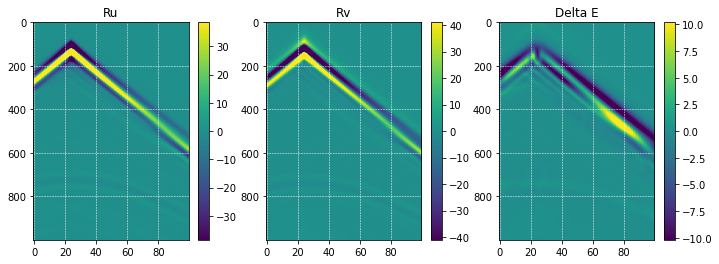

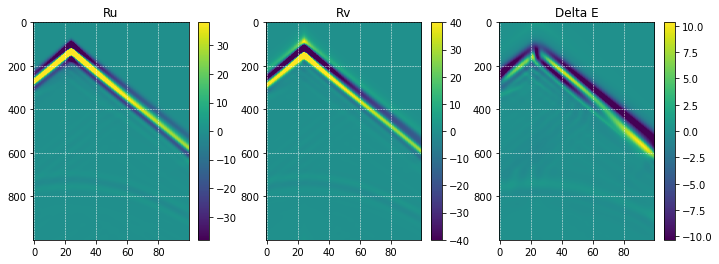

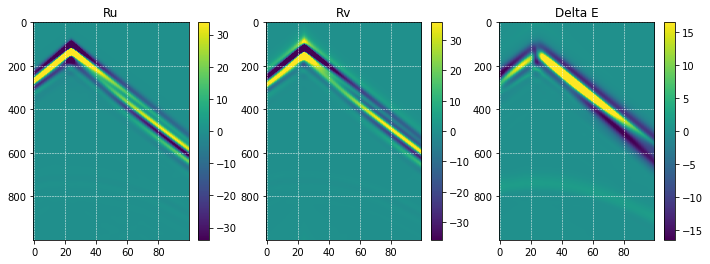

In [65]:
uobs=read_su('results_fwd/dsyn_Shot0001.su')
vobs=hilb(uobs)
Eobs=np.sqrt(uobs**2+vobs**2)
# phobs=np.arctan2(vobs,uobs)

res1='results_DeltaE_homo_inv/'
res2='results_DeltaEcos_homo_inv/'
res3='results_Deltau_homo_inv/'

plt.figure(figsize=(16,4))
usyn=read_su(res1+'Ru_Shot0001.su')
vsyn=read_su(res1+'Rv_Shot0001.su')
Esyn=np.sqrt(usyn**2+vsyn**2)
# phsyn=np.arctan2(vsyn,usyn)
plt.subplot(1,4,1); imshow(usyn, title='Ru',perc=98)
plt.subplot(1,4,2); imshow(vsyn, title='Rv',perc=98)
plt.subplot(1,4,3); imshow(Esyn, title='RE',perc=98)
plt.subplot(1,4,3); imshow(Eobs-Esyn, title='Delta E',perc=98)

plt.figure(figsize=(16,4))
usyn=read_su(res2+'Ru_Shot0001.su')
vsyn=read_su(res2+'Rv_Shot0001.su')
Esyn=np.sqrt(usyn**2+vsyn**2)
# phsyn=np.arctan2(vsyn,usyn)
plt.subplot(1,4,1); imshow(usyn, title='Ru',perc=98)
plt.subplot(1,4,2); imshow(vsyn, title='Rv',perc=98)
plt.subplot(1,4,3); imshow(Esyn, title='RE',perc=98)
plt.subplot(1,4,3); imshow(Eobs-Esyn, title='Delta E',perc=98)


plt.figure(figsize=(16,4))
usyn=read_su(res3+'Ru_Shot0001.su')
vsyn=read_su(res3+'Rv_Shot0001.su')
Esyn=np.sqrt(usyn**2+vsyn**2)
# phsyn=np.arctan2(vsyn,usyn)
plt.subplot(1,4,1); imshow(usyn, title='Ru',perc=98)
plt.subplot(1,4,2); imshow(vsyn, title='Rv',perc=98)
plt.subplot(1,4,3); imshow(Esyn, title='RE',perc=98)
plt.subplot(1,4,3); imshow(Eobs-Esyn, title='Delta E',perc=98)

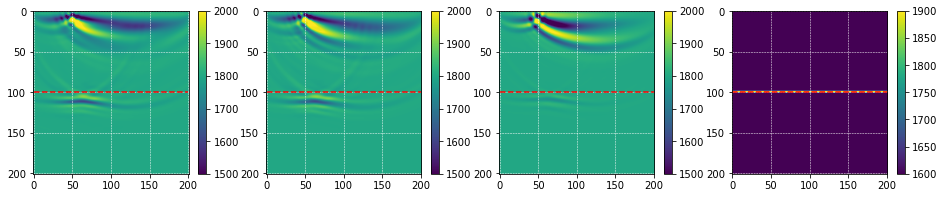

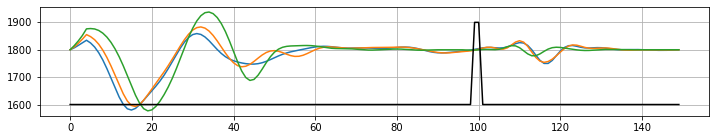

In [69]:
res1='results_DeltaE_homo_inv/model_Iter6'
res2='results_DeltaEcos_homo_inv/model_Iter6'
res3='results_Deltau_homo_inv/model_Iter4'

model1=read(res1)
model2=read(res2)
model3=read(res3)

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(model1      ); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(model2      ); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(model3      ); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(read('true')); plt.plot([0,200],[100,100],'--r')


plt.figure(figsize=(12,2))
plt.plot(model1[:150,100])
plt.plot(model2[:150,100])
plt.plot(model3[:150,100])
plt.plot(read('true')[:150,100],'k')
plt.grid(visible=True, axis='both', which='both')

## [all below wait] PFEI ExactEnv iterate homo=1500

In [29]:
!makevel nz=$nz nx=$nx v000=1500 > model
#!makevel nz=1   nx=201 v000=60   > topo

!cp setup_default setup
!echo 'DIR_OUT   results_homo' >> setup
!echo "WEIGHTING     none" >> setup
!echo "SMOOTHING     none" >> setup
!echo 'JOB   optimization' >> setup
!echo 'SNAPSHOT      none' >> setup

#!echo "WEIGHTING_4WAVELET  'aoffset_range:300:2000'" >> setup
#!echo "WEIGHTING           'aoffset_range:300:2000  polygon:wei'" >> setup

!mkdir results_homo
run(out='results_homo/out')

mkdir: cannot create directory ‘results_homo’: File exists
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
mv: cannot stat 'results_homo/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_homo/dsyn_Shot0001.su': No such file or directory
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpect

In [30]:
!cat results_homo/optimization.log

 **********************************************************************
    NONLINEAR CONJUGATE GRADIENT ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =   10
     Max linesearches allowed =   12
     Max gradients allowed    =   40
     Linesearch scaler        =1.88914186E-04
     Initial gradient L1norm (║g0║₁)  =8.0803E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 2.6492E-01 100.000  100.000     -1.49E+00
            1      2  1.00E+00       2.2138E-01                      -1.06E+00   T T
     1             2                 2.2138E-01  83.568   78.824     -1.20E+00
 -----------------------------------------------------------------------------------

In [31]:
!grep Angle results_homo/out

 Angle between p★u & q★v (w/ mask): 7.50678825°
 Angle between p★u & q★v (w/ mask): 2.74751687°
 Angle between p★u & q★v (w/ mask): 0.641939521°
 Angle between p★u & q★v (w/ mask): 0.195835263°
 Angle between p★u & q★v (w/ mask): 0.570612252°
 Angle between p★u & q★v (w/ mask): 0.431600720°
 Angle between p★u & q★v (w/ mask): 0.309642971°
 Angle between p★u & q★v (w/ mask): 0.296735406°
 Angle between p★u & q★v (w/ mask): 0.334550202°
 Angle between p★u & q★v (w/ mask): 0.276245594°
 Angle between p★u & q★v (w/ mask): 0.309642971°
 Angle between p★u & q★v (w/ mask): 0.287355393°
 Angle between p★u & q★v (w/ mask): 0.297394097°
 Angle between p★u & q★v (w/ mask): 0.281855226°
 Angle between p★u & q★v (w/ mask): 0.992486715°
 Angle between p★u & q★v (w/ mask): 0.970959783°
 Angle between p★u & q★v (w/ mask): 1.00522053°
 Angle between p★u & q★v (w/ mask): 0.967123151°
 Angle between p★u & q★v (w/ mask): 0.994849861°
 Angle between p★u & q★v (w/ mask): 0.984171093°
 Angle between p★u & q★

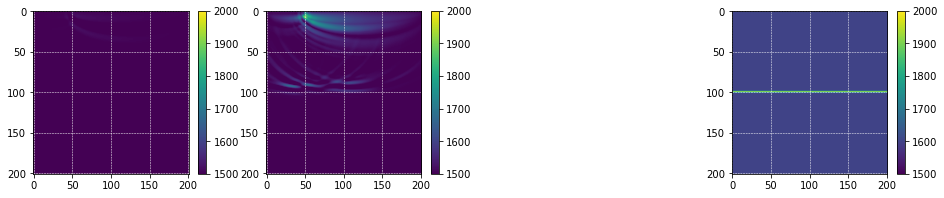

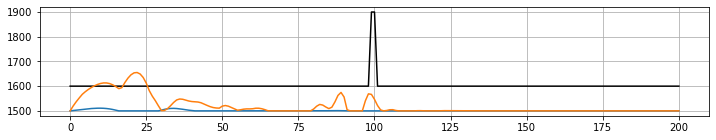

In [33]:
res='results_homo/'

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(read(res+'model_Iter1'),clip=(1500,2000))
plt.subplot(1,4,2); imshow(read(res+'model_Iter6'),clip=(1500,2000))
# plt.subplot(1,4,3); imshow(read(res+'model_Iter11'),clip=(1500,2000))
plt.subplot(1,4,4); imshow(read('true'           ),clip=(1500,2000))

plt.figure(figsize=(12,2))
plt.plot(read('true'           )[:,100],'k')
plt.plot(read(res+'model_Iter1')[:,100])
plt.plot(read(res+'model_Iter6')[:,100])
# plt.plot(read(res+'model_Iter11')[:,100])
plt.grid(visible=True, axis='both', which='both')

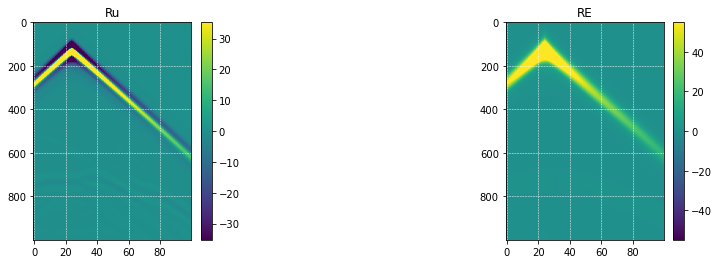

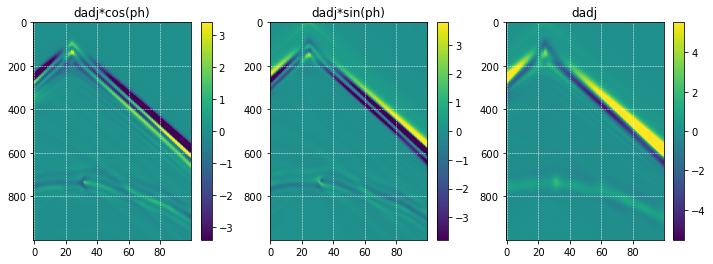

In [36]:
res='results_homo/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Iter6_Shot0001.su'), title='Ru',perc=98)
# plt.subplot(1,3,2); imshow(read_su(res+'Rv_Iter6_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'RE_Iter6_Shot0001.su'), title='RE',perc=98)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'dadj*cos(ph)_Shot0001.su'),title='dadj*cos(ph)',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'dadj*sin(ph)_Shot0001.su'),title='dadj*sin(ph)',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Iter7_Shot0001.su'),title='dadj',perc=98)

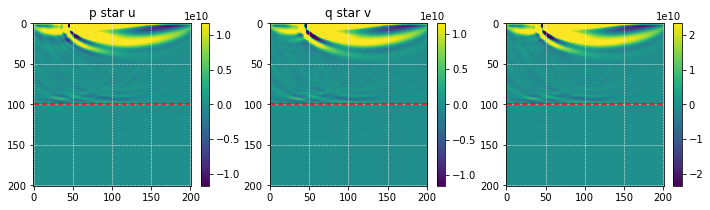

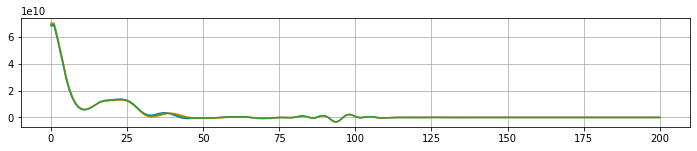

In [37]:
res='results_homo/'

term1=read(res+'p_star_u%rp_ddsp')
term2=read(res+'q_star_v%rp_ddsp')

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(term1,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,3,2); imshow(term2,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,3,3); imshow(term1+term2,           perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=term1[:,100]; plt.plot(tr1)
tr2=term2[:,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
plt.grid(visible=True, axis='both', which='both')

## PFEI ExactEnv iterate homo=1800

In [38]:
!makevel nz=$nz nx=$nx v000=1800 > model
#!makevel nz=1   nx=201 v000=60   > topo

!cp setup_default setup
!echo 'DIR_OUT   results_homo18' >> setup
!echo "WEIGHTING     none" >> setup
!echo "SMOOTHING     none" >> setup
!echo 'JOB   optimization' >> setup
!echo 'SNAPSHOT      none' >> setup

#!echo "WEIGHTING_4WAVELET  'aoffset_range:300:2000'" >> setup
#!echo "WEIGHTING           'aoffset_range:300:2000  polygon:wei'" >> setup

!mkdir results_homo18
run(out='results_homo18/out')

sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
mv: cannot stat 'results_homo18/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_homo18/dsyn_Shot0001.su': No such file or directory
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax er

In [39]:
!cat results_homo18/optimization.log

 **********************************************************************
    NONLINEAR CONJUGATE GRADIENT ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =   10
     Max linesearches allowed =   12
     Max gradients allowed    =   40
     Linesearch scaler        =2.40979774E-04
     Initial gradient L1norm (║g0║₁)  =8.0802E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 8.6963E-01 100.000  100.000     -2.90E+01
            1      2  1.00E+00       7.9782E-01                      -3.47E+01   T F
            2      3  1.00E+01       3.7665E-01                      -7.69E+00   T T
     1             3                 3.7665E-01  43.312   61.280     -2.41E+00

In [40]:
!grep Angle results_homo18/out

 Angle between p★u & q★v (w/ mask): 1.46072125°
 Angle between p★u & q★v (w/ mask): 1.62172341°
 Angle between p★u & q★v (w/ mask): 40.5311203°
 Angle between p★u & q★v (w/ mask): 1.68771601°
 Angle between p★u & q★v (w/ mask): NaN°
 Angle between p★u & q★v (w/ mask): NaN°
 Angle between p★u & q★v (w/ mask): 0.511290073°
 Angle between p★u & q★v (w/ mask): 0.868405759°
 Angle between p★u & q★v (w/ mask): 0.997795820°
 Angle between p★u & q★v (w/ mask): 1.16078985°
 Angle between p★u & q★v (w/ mask): 1.31923091°
 Angle between p★u & q★v (w/ mask): 1.46847081°
 Angle between p★u & q★v (w/ mask): 1.37927532°
 Angle between p★u & q★v (w/ mask): 1.34697449°
 Angle between p★u & q★v (w/ mask): 18.0002041°
 Angle between p★u & q★v (w/ mask): 7.62308073°
 Angle between p★u & q★v (w/ mask): 5.02991056°
 Angle between p★u & q★v (w/ mask): 0.541763663°
 Angle between p★u & q★v (w/ mask): 1.97565937°
 Angle between p★u & q★v (w/ mask): 3.49871922°
 Angle between p★u & q★v (w/ mask): 3.95948052°
 A

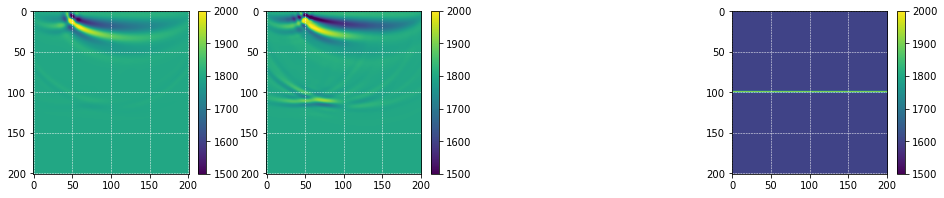

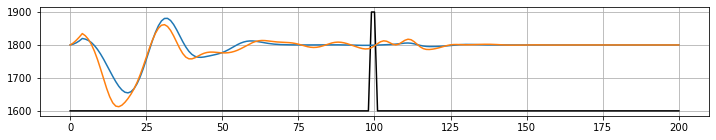

In [44]:
res='results_homo18/'

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(read(res+'model_Iter1'),clip=(1500,2000))
plt.subplot(1,4,2); imshow(read(res+'model_Iter5'),clip=(1500,2000))
# plt.subplot(1,4,3); imshow(read(res+'model_Iter11'),clip=(1500,2000))
plt.subplot(1,4,4); imshow(read('true'           ),clip=(1500,2000))

plt.figure(figsize=(12,2))
plt.plot(read('true'           )[:,100],'k')
plt.plot(read(res+'model_Iter1')[:,100])
plt.plot(read(res+'model_Iter5')[:,100])
# plt.plot(read(res+'model_Iter11')[:,100])
plt.grid(visible=True, axis='both', which='both')

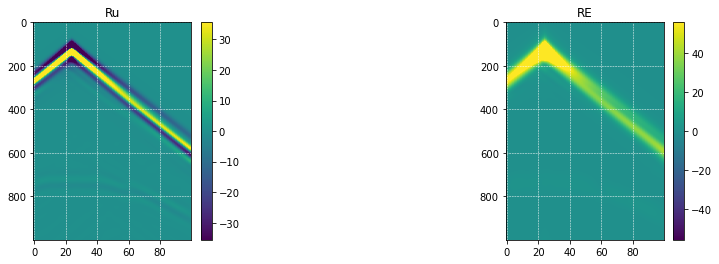

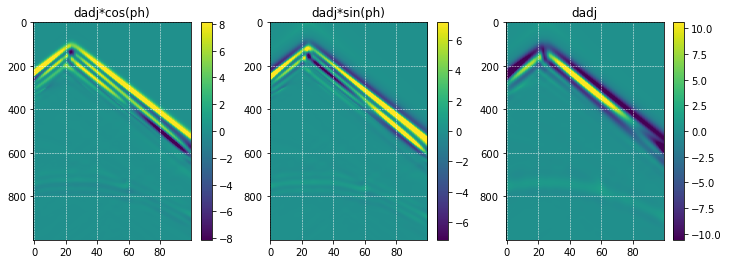

In [45]:
res='results_homo18/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Iter5_Shot0001.su'), title='Ru',perc=98)
# plt.subplot(1,3,2); imshow(read_su(res+'Rv_Iter6_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'RE_Iter5_Shot0001.su'), title='RE',perc=98)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'dadj*cos(ph)_Shot0001.su'),title='dadj*cos(ph)',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'dadj*sin(ph)_Shot0001.su'),title='dadj*sin(ph)',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Iter5_Shot0001.su'),title='dadj',perc=98)

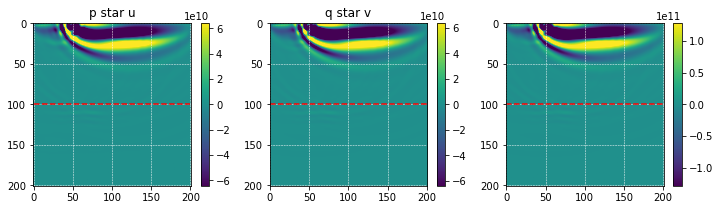

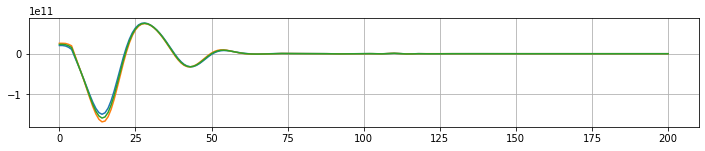

In [46]:
res='results_homo18/'

term1=read(res+'p_star_u%rp_ddsp')
term2=read(res+'q_star_v%rp_ddsp')

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(term1,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,3,2); imshow(term2,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,3,3); imshow(term1+term2,           perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=term1[:,100]; plt.plot(tr1)
tr2=term2[:,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
plt.grid(visible=True, axis='both', which='both')

## PFEI ExactEnv iterate 2layer=1700/1800

In [47]:
model=np.zeros((nz,nx))
model[:,:]=1700.
model[int(nz/2)-1:int(nz/2)+1,:]=1800.
model.T.astype('float32').tofile('model')

#!makevel nz=1   nx=201 v000=60   > topo

!cp setup_default setup
!echo 'DIR_OUT   results_2layer' >> setup
!echo "WEIGHTING     none" >> setup
!echo "SMOOTHING     none" >> setup
!echo 'JOB   optimization' >> setup
!echo 'SNAPSHOT      none' >> setup

#!echo "WEIGHTING_4WAVELET  'aoffset_range:300:2000'" >> setup
#!echo "WEIGHTING           'aoffset_range:300:2000  polygon:wei'" >> setup

!mkdir results_2layer
run(out='results_2layer/out')

mkdir: cannot create directory ‘results_2layer’: File exists
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
mv:

In [48]:
!cat results_2layer/optimization.log

 **********************************************************************
    NONLINEAR CONJUGATE GRADIENT ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =   10
     Max linesearches allowed =   12
     Max gradients allowed    =   40
     Linesearch scaler        =3.45728477E-04
     Initial gradient L1norm (║g0║₁)  =8.0802E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 4.1194E-01 100.000  100.000     -9.21E+00
            1      2  1.00E+00       3.4545E-01                      -1.21E+01   T F
            2      3  1.00E+01       5.4488E-01                      -2.11E+01   F F
            3      4  5.50E+00       1.9987E-01                      -1.26E+01

In [49]:
!grep Angle results_2layer/out

 Angle between p★u & q★v (w/ mask): 1.59642649°
 Angle between p★u & q★v (w/ mask): 1.04548824°
 Angle between p★u & q★v (w/ mask): 1.69269478°
 Angle between p★u & q★v (w/ mask): 1.48753691°
 Angle between p★u & q★v (w/ mask): 1.45817363°
 Angle between p★u & q★v (w/ mask): 1.61143363°
 Angle between p★u & q★v (w/ mask): 1.55015492°
 Angle between p★u & q★v (w/ mask): 1.57532525°
 Angle between p★u & q★v (w/ mask): 1.59863138°
 Angle between p★u & q★v (w/ mask): 1.60681224°
 Angle between p★u & q★v (w/ mask): 1.59703922°
 Angle between p★u & q★v (w/ mask): 1.60559380°
 Angle between p★u & q★v (w/ mask): 1.59703922°
 Angle between p★u & q★v (w/ mask): 1.65540326°
 Angle between p★u & q★v (w/ mask): 8.31212425°
 Angle between p★u & q★v (w/ mask): 5.31802368°
 Angle between p★u & q★v (w/ mask): 4.20253563°
 Angle between p★u & q★v (w/ mask): 1.74786854°
 Angle between p★u & q★v (w/ mask): 3.27189565°
 Angle between p★u & q★v (w/ mask): 3.25948620°
 Angle between p★u & q★v (w/ mask): 3.08

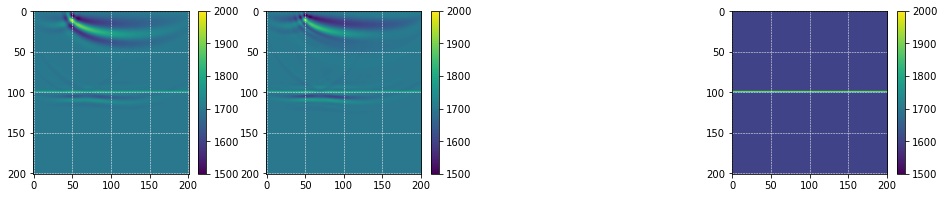

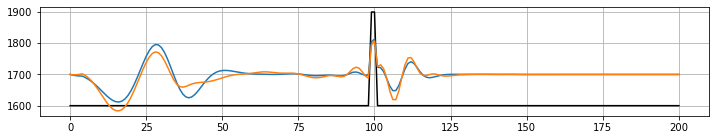

In [53]:
res='results_2layer/'

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(read(res+'model_Iter1'),clip=(1500,2000))
plt.subplot(1,4,2); imshow(read(res+'model_Iter5'),clip=(1500,2000))
# plt.subplot(1,4,3); imshow(read(res+'model_Iter11'),clip=(1500,2000))
plt.subplot(1,4,4); imshow(read('true'           ),clip=(1500,2000))

plt.figure(figsize=(12,2))
plt.plot(read('true'           )[:,100],'k')
plt.plot(read(res+'model_Iter1')[:,100])
plt.plot(read(res+'model_Iter5')[:,100])
# plt.plot(read(res+'model_Iter11')[:,100])
plt.grid(visible=True, axis='both', which='both')

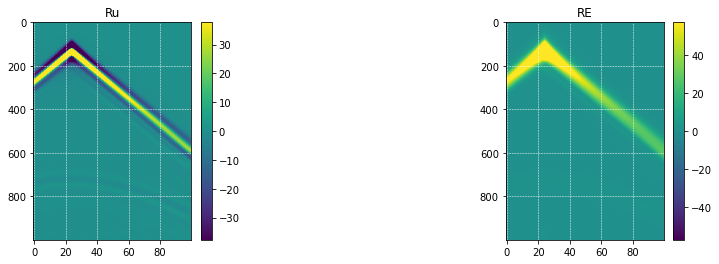

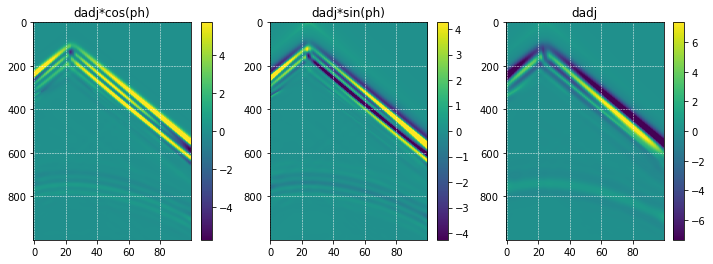

In [55]:
res='results_2layer/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Iter4_Shot0001.su'), title='Ru',perc=98)
# plt.subplot(1,3,2); imshow(read_su(res+'Rv_Iter6_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'RE_Iter4_Shot0001.su'), title='RE',perc=98)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'dadj*cos(ph)_Shot0001.su'),title='dadj*cos(ph)',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'dadj*sin(ph)_Shot0001.su'),title='dadj*sin(ph)',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Iter4_Shot0001.su'),title='dadj',perc=98)

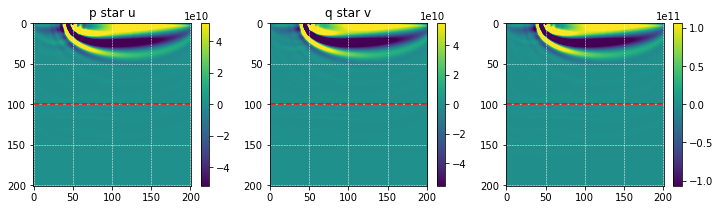

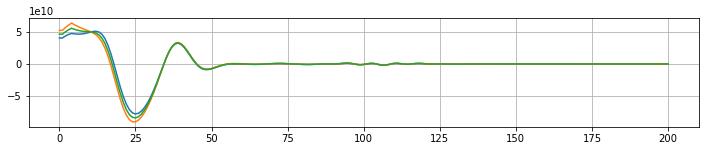

In [56]:
res='results_2layer/'

term1=read(res+'p_star_u%rp_ddsp')
term2=read(res+'q_star_v%rp_ddsp')

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(term1,title='p star u',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,3,2); imshow(term2,title='q star v',perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,3,3); imshow(term1+term2,           perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(12,2))
tr1=term1[:,100]; plt.plot(tr1)
tr2=term2[:,100]; plt.plot(tr2)
plt.plot((tr1+tr2)/2)
plt.grid(visible=True, axis='both', which='both')